In [25]:
import sys
sys.path.append('../')
from quantization.posttraining.layer_scale_optimization import *
from collections import namedtuple
from tqdm import tqdm
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from quantization.methods.clipped_uniform import L2NormQuantization, L3NormQuantization, AciqLaplaceQuantization
import ipyvolume as ipv
from matplotlib import cm
from colorama import Fore
from scipy.interpolate import interp2d
import ipywidgets as widgets

In [2]:
args_dict = {'arch': 'resnet18', 'custom_resnet': True, 'pretrained': True, 'dataset': 'imagenet', 'gpu_ids': [0], 'datapath': None,
                     'batch_size': 256, 'shuffle': True, 'workers': 25, 'print_freq': 10,
                     'cal_batch_size': 256, 'cal_set_size': 256}
args_dict['bit_act'] = 2
args_dict['bit_weights'] = None
args_dict['pre_relu'] = False
args_dict['qtype'] = 'max_static'
args = argparse.Namespace()
for k in args_dict:
    setattr(args, k, args_dict[k])
args

Namespace(arch='resnet18', batch_size=256, bit_act=2, bit_weights=None, cal_batch_size=256, cal_set_size=256, custom_resnet=True, datapath=None, dataset='imagenet', gpu_ids=[0], pre_relu=False, pretrained=True, print_freq=10, qtype='max_static', shuffle=True, workers=25)

In [3]:
if 'inf_model' in globals():
    del inf_model

# create model
# Always enable shuffling to avoid issues where we get bad results due to weak statistics
inf_model = CnnModel(args.arch, args.custom_resnet, args.pretrained, args.dataset, args.gpu_ids, args.datapath,
                     batch_size=args.batch_size, shuffle=True, workers=args.workers, print_freq=args.print_freq,
                     cal_batch_size=args.cal_batch_size, cal_set_size=args.cal_set_size)

all_layers = []
if args.bit_weights is not None:
    all_layers += [n for n, m in inf_model.model.named_modules() if isinstance(m, nn.Conv2d)]
if args.bit_act is not None:
    all_layers += [n for n, m in inf_model.model.named_modules() if isinstance(m, nn.ReLU)]
if args.bit_act is not None and 'mobilenet' in args.arch:
    all_layers += [n for n, m in inf_model.model.named_modules() if isinstance(m, nn.ReLU6)]
    
if 'mq' in globals():
    del mq

layers = [all_layers[1], all_layers[2]]
replacement_factory = {nn.ReLU: ActivationModuleWrapperPost,
                       nn.ReLU6: ActivationModuleWrapperPost,
                       nn.Conv2d: ParameterModuleWrapperPost}
mq = ModelQuantizer(inf_model.model, args, layers, replacement_factory)

loss = inf_model.evaluate_calibration()
print("Initial loss: {:.4f}".format(loss.item()))
max_point = mq.get_clipping()

ActivationModuleWrapperPost - layer1.0.relu1 | MaxAbsStaticQuantization - [alpha: 4.1600, bits: 2, symmetric: False, tails: False, ] | cuda:0
ActivationModuleWrapperPost - layer1.0.relu2 | MaxAbsStaticQuantization - [alpha: 6.5623, bits: 2, symmetric: False, tails: False, ] | cuda:0
Initial loss: 10.9588


In [4]:
n = 41
x = np.linspace(0.01, max_point[0].item(), n)
y = np.linspace(0.01, max_point[1].item(), n)
X, Y = np.meshgrid(x, y)
Z = np.empty((n, n))
for i, x_ in enumerate(tqdm(x)):
    for j, y_ in enumerate(y):
        # set clip value to qwrappers
        scales = np.array([X[i, j], Y[i, j]])
        mq.set_clipping(scales, inf_model.device)

        # evaluate with clipping
        loss = inf_model.evaluate_calibration()
        Z[i][j] = loss.item()

100%|██████████| 41/41 [03:51<00:00,  5.64s/it]


In [5]:
args.qtype = 'l2_norm'
if 'inf_model' in globals():
    del inf_model
inf_model = CnnModel(args.arch, args.custom_resnet, args.pretrained, args.dataset, args.gpu_ids, args.datapath,
                     batch_size=args.batch_size, shuffle=True, workers=args.workers, print_freq=args.print_freq,
                     cal_batch_size=args.cal_batch_size, cal_set_size=args.cal_set_size)
if 'mq' in globals():
    del mq
mq = ModelQuantizer(inf_model.model, args, layers, replacement_factory)
l2_loss = inf_model.evaluate_calibration()
print("loss l2: {:.4f}".format(l2_loss.item()))
l2_point = mq.get_clipping()

ActivationModuleWrapperPost - layer1.0.relu1 | L2NormQuantization - [alpha: 0.5123, bits: 2, symmetric: False, tails: False, ] | cuda:0
ActivationModuleWrapperPost - layer1.0.relu2 | L2NormQuantization - [alpha: 1.3056, bits: 2, symmetric: False, tails: False, ] | cuda:0
loss l2: 1.5450


In [6]:
args.qtype = 'l3_norm'
if 'inf_model' in globals():
    del inf_model
inf_model = CnnModel(args.arch, args.custom_resnet, args.pretrained, args.dataset, args.gpu_ids, args.datapath,
                     batch_size=args.batch_size, shuffle=True, workers=args.workers, print_freq=args.print_freq,
                     cal_batch_size=args.cal_batch_size, cal_set_size=args.cal_set_size)
if 'mq' in globals():
    del mq
mq = ModelQuantizer(inf_model.model, args, layers, replacement_factory)
l3_loss = inf_model.evaluate_calibration()
print("loss l3: {:.4f}".format(l3_loss.item()))
l3_point = mq.get_clipping()

ActivationModuleWrapperPost - layer1.0.relu1 | L3NormQuantization - [alpha: 0.7027, bits: 2, symmetric: False, tails: False, ] | cuda:0
ActivationModuleWrapperPost - layer1.0.relu2 | L3NormQuantization - [alpha: 1.6676, bits: 2, symmetric: False, tails: False, ] | cuda:0
loss l3: 1.5972


In [7]:
args.qtype = 'aciq_laplace'
if 'inf_model' in globals():
    del inf_model
inf_model = CnnModel(args.arch, args.custom_resnet, args.pretrained, args.dataset, args.gpu_ids, args.datapath,
                     batch_size=args.batch_size, shuffle=True, workers=args.workers, print_freq=args.print_freq,
                     cal_batch_size=args.cal_batch_size, cal_set_size=args.cal_set_size)
if 'mq' in globals():
    del mq
mq = ModelQuantizer(inf_model.model, args, layers, replacement_factory)
laplace_loss = inf_model.evaluate_calibration()
print("loss laplace: {:.4f}".format(laplace_loss.item()))
laplace_point = mq.get_clipping()

ActivationModuleWrapperPost - layer1.0.relu1 | AciqLaplaceQuantization - [alpha: 0.8124, bits: 2, symmetric: False, tails: False, ] | cuda:0
ActivationModuleWrapperPost - layer1.0.relu2 | AciqLaplaceQuantization - [alpha: 2.1918, bits: 2, symmetric: False, tails: False, ] | cuda:0
loss laplace: 1.6810


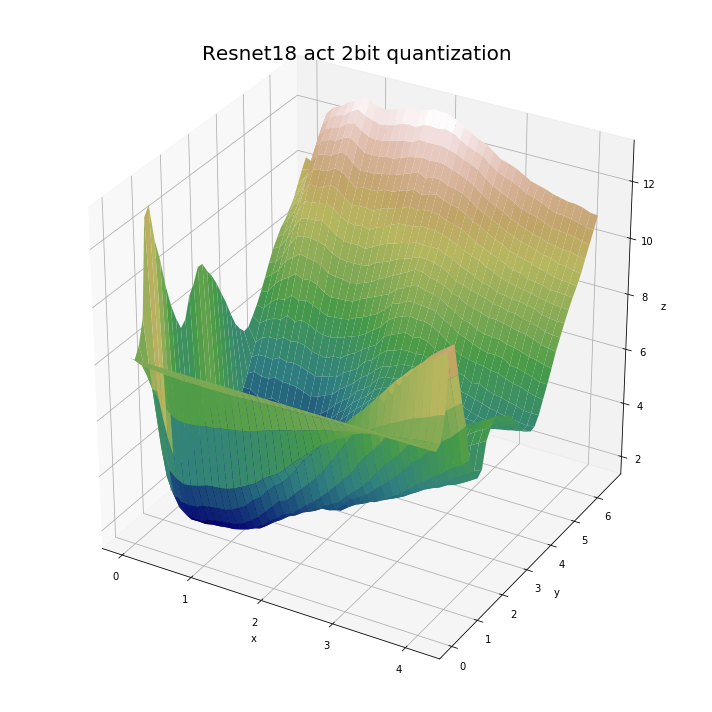

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 100, cmap=cm.CMRmap)
ax.plot_surface(X, Y, Z, cmap=cm.gist_earth)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.set_title('Resnet18 act 2bit quantization', size=20)
plt.tight_layout()

In [9]:
# from scipy.interpolate import interp2d
# f = interp2d(X, Y, Z, kind='cubic')
# x_intr = np.linspace(0.01, max_point[0].item(), 300)
# y_intr = np.linspace(0.01, max_point[1].item(), 300)
# Zintr = f(x_intr, y_intr)
# Xintr, Yintr = np.meshgrid(x_intr, y_intr)

# fig1 = ipv.figure()
# colormap = cm.spectral
# znorm = Zintr - Zintr.min()
# znorm /= znorm.ptp()
# znorm.min(), znorm.max()
# color = colormap(znorm)
# mesh = ipv.plot_surface(Xintr, Yintr, Zintr, color=color[...,:3])
# # ipv.plot_wireframe(Xintr, Zintr, Yintr, color="black")
# ipv.style.use('minimal')
# ipv.show()

In [41]:
def ipv_point(p, color='red'):
    x1, x2, x3 = np.array([p[0]]), np.array([p[1]]), np.array([p[2]])
    ipv.scatter(x1, x2, x3, size=3., color=color, marker='sphere')

f = interp2d(X, Y, Z, kind='linear')
x_intr = np.linspace(0., max_point[0].item(), 300)
y_intr = np.linspace(0., max_point[1].item(), 300)
Zintr = f(x_intr, y_intr)
Xintr, Yintr = np.meshgrid(x_intr, y_intr)

fig = ipv.figure()
colormap = cm.spectral
znorm = Zintr - Zintr.min()
znorm /= znorm.ptp()
znorm.min(), znorm.max()
color = colormap(znorm)
mesh = ipv.plot_surface(Xintr, Yintr, Zintr, color=color[...,:3])

ipv_point(np.array([l2_point[0].item(), l2_point[1].item(), l2_loss.item()+0.2]), color='red')
ipv_point(np.array([l3_point[0].item(), l3_point[1].item(), l3_loss.item()+0.2]), color='green')
ipv_point(np.array([laplace_point[0].item(), laplace_point[1].item(), laplace_loss.item()+0.2]), color='white')

ipv.style.use('minimal')
ipv.show()

print(Fore.RED + "L2")
print(Fore.GREEN + "L3")
print(Fore.WHITE + "Laplace")

L2
L3
Laplace


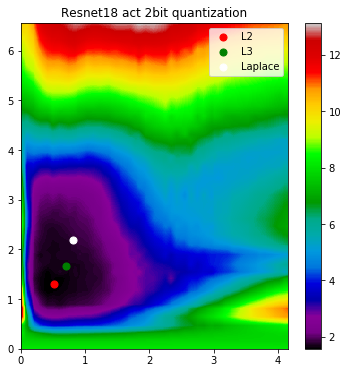

In [48]:
def plot_p(ax, p, c='r'):
    ax.scatter([p[0]], [p[1]], color=c, s=50);

from pylab import rcParams
rcParams['figure.figsize'] = 6, 6

x = Xintr
y = Yintr
z = Zintr

cmesh = ax.pcolormesh(x, y, z, cmap='RdBu')

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap=cm.spectral)
ax.set_title('Resnet18 act 2bit quantization')
# set the limits of the plot to the limits of the data
fig.colorbar(c, ax=ax)

plot_p(ax, [l2_point[0].item(), l2_point[1].item()], 'r')
plot_p(ax, [l3_point[0].item(), l3_point[1].item()], 'g')
plot_p(ax, [laplace_point[0].item(), laplace_point[1].item()], 'w')

plt.legend(['L2', 'L3', 'Laplace'])

plt.show()